In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.metrics import root_mean_squared_error

def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)


def train_elastic_net_models(data, dataset_label="bulk", output_dir="results/elastic_net", num_pcs=None):
    os.makedirs(output_dir, exist_ok=True)

    non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
    gene_cols = [col for col in data.columns if col not in non_features]

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

    results = []

    min_samples = 125
    
    
      # Minimum number of cell lines per drug

    for drug_id in sorted(data["DRUG_ID"].unique()):
        df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
        if df["SANGER_MODEL_ID"].nunique() < min_samples:
            continue


        X = df[gene_cols].values
        y = df["LN_IC50"].values

        model = ElasticNetCV(
            alphas=[0.01, 0.1, 1.0, 10.0],
            l1_ratio=[0.1, 0.5, 0.9],
            cv=kf,
            max_iter=5000,
            random_state=42
        )

        # Check for duplicate cell lines in this drug's data
        duplicates = df["SANGER_MODEL_ID"].duplicated().sum()
        unique_cell_lines = df["SANGER_MODEL_ID"].nunique()
        total_rows = df.shape[0]

        print(f"\n🧪 Drug: {drug_id}")
        print(f"Total rows: {total_rows}")
        print(f"Unique cell lines: {unique_cell_lines}")
        print(f"Duplicate entries (same cell line): {duplicates}")

        # Optional: see a sample
        print(df["SANGER_MODEL_ID"].value_counts().head())

        model.fit(X, y)

        # CV Performance
        rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
        r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)
        n_unique_lines = df["SANGER_MODEL_ID"].nunique()

        # Skip if not enough unique cell lines
        if n_unique_lines < min_samples:
            continue

        results.append({
            "DRUG_ID": drug_id,
            "n_samples": n_unique_lines,  # ✅ correct
            "alpha": model.alpha_,
            "l1_ratio": model.l1_ratio_,
            "rmse_mean": -rmse_scores.mean(),
            "rmse_std": rmse_scores.std(),
            "r2_mean": r2_scores.mean(),
            "r2_std": r2_scores.std()
        })

    results_df = pd.DataFrame(results)

    postfix = f"{num_pcs}_pcs" if num_pcs is not None else dataset_label
    results_csv = os.path.join(output_dir, f"elastic_net_results_{postfix}.csv")
    results_df.to_csv(results_csv, index=False)

    print(f"✅ Saved results to: {results_csv}")

    # Plot RMSE
    plt.figure(figsize=(8, 5))
    sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
    plt.title(f"RMSE Distribution ({dataset_label})")
    plt.xlabel("RMSE")
    plt.ylabel("Number of Drugs")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"elastic_net_rmse_{postfix}.png"), dpi=300)
    plt.show()

    # Plot R²
    plt.figure(figsize=(8, 5))
    sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
    plt.title(f"R² Distribution ({dataset_label})")
    plt.xlabel("R² Score")
    plt.ylabel("Number of Drugs")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"elastic_net_r2_{postfix}.png"), dpi=300)
    plt.show()

    return results_df



🧪 Drug: 133
Total rows: 134
Unique cell lines: 134
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00317    1
SIDM00629    1
SIDM00663    1
SIDM01082    1
SIDM00723    1
Name: count, dtype: int64

🧪 Drug: 134
Total rows: 134
Unique cell lines: 134
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00762    1
SIDM00082    1
SIDM00399    1
SIDM00681    1
SIDM00980    1
Name: count, dtype: int64

🧪 Drug: 135
Total rows: 133
Unique cell lines: 133
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00607    1
SIDM00399    1
SIDM01156    1
SIDM00108    1
SIDM00097    1
Name: count, dtype: int64

🧪 Drug: 136
Total rows: 135
Unique cell lines: 135
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00988    1
SIDM01103    1
SIDM00921    1
SIDM00997    1
SIDM00235    1
Name: count, dtype: int64

🧪 Drug: 140
Total rows: 135
Unique cell lines: 135
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM01112    1
SIDM00675    1
SIDM00082    1
SIDM00481    1
SIDM01

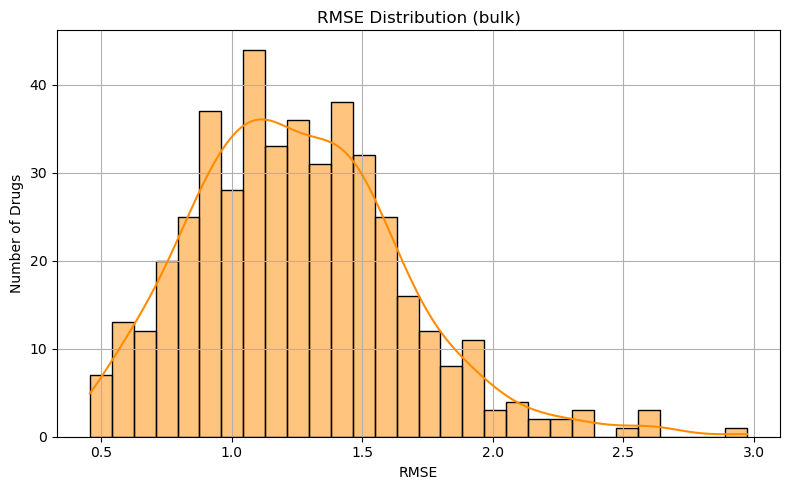

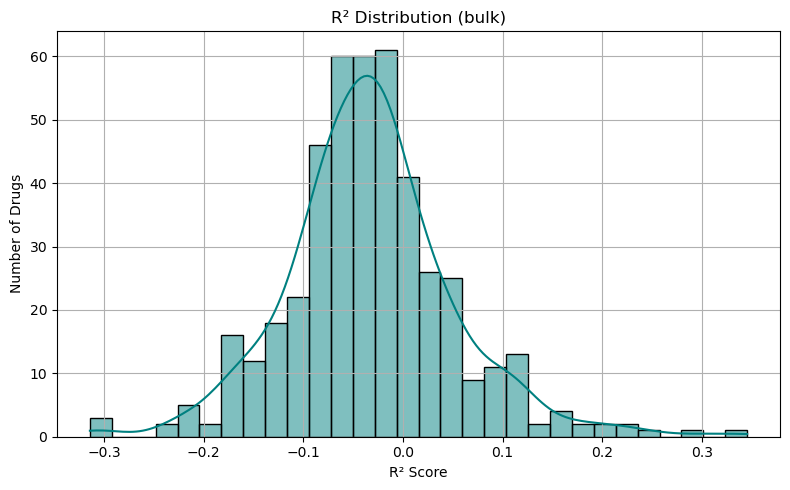


🧪 Drug: 133
Total rows: 134
Unique cell lines: 134
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00317    1
SIDM00629    1
SIDM00663    1
SIDM01082    1
SIDM00723    1
Name: count, dtype: int64

🧪 Drug: 134
Total rows: 134
Unique cell lines: 134
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00762    1
SIDM00082    1
SIDM00399    1
SIDM00681    1
SIDM00980    1
Name: count, dtype: int64

🧪 Drug: 135
Total rows: 133
Unique cell lines: 133
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00607    1
SIDM00399    1
SIDM01156    1
SIDM00108    1
SIDM00097    1
Name: count, dtype: int64

🧪 Drug: 136
Total rows: 135
Unique cell lines: 135
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM00988    1
SIDM01103    1
SIDM00921    1
SIDM00997    1
SIDM00235    1
Name: count, dtype: int64

🧪 Drug: 140
Total rows: 135
Unique cell lines: 135
Duplicate entries (same cell line): 0
SANGER_MODEL_ID
SIDM01112    1
SIDM00675    1
SIDM00082    1
SIDM00481    1
SIDM01

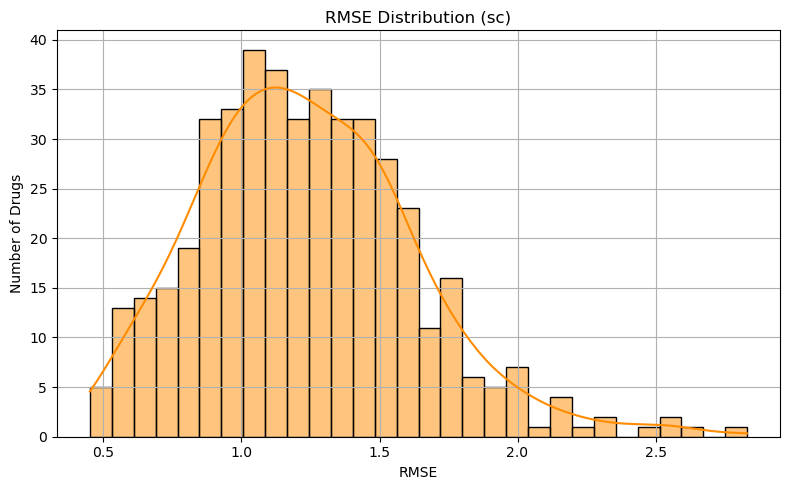

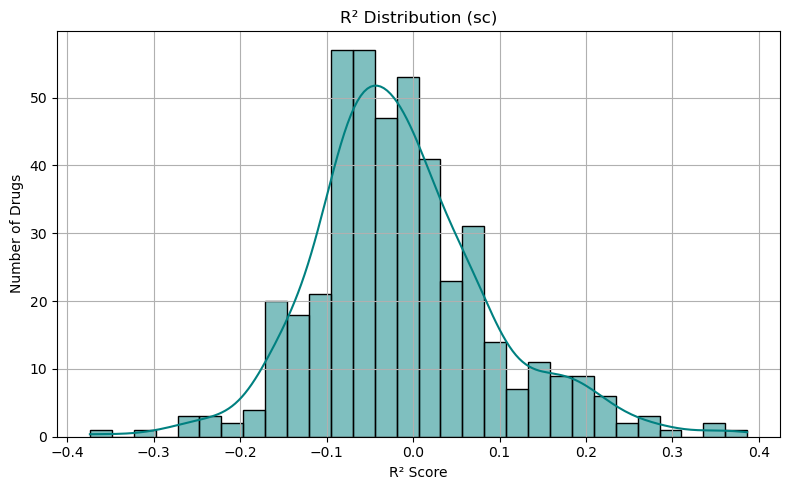

In [6]:
# Load the aligned training datasets (if not already)
bulk_data = pd.read_csv("data/training_data_bulk.csv")
sc_data = pd.read_csv("data/training_data_sc.csv")

# Make sure log IC50 is present
for df in [bulk_data, sc_data]:
    if "LN_IC50" not in df.columns:
        df["LN_IC50"] = np.log1p(df["LN_IC50"])

# Run training
results_bulk = train_elastic_net_models(bulk_data, dataset_label="bulk")
results_sc = train_elastic_net_models(sc_data, dataset_label="sc")
